In [38]:
import cv2
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import geopy.distance as distance
import geopandas as gpd
from shapely.geometry import Point

import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

from data_collection import *
#from data_collection import get_bounding_box, get_date_range, normalize_landsat, normalize_sentinel

In [39]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

sat_image_catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

In [40]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

In [41]:
# read .csv files
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv")
submission_format = pd.read_csv(DATA_DIR / "submission_format.csv", index_col=0)
metadata = pd.read_csv(DATA_DIR / "metadata.csv")

In [42]:
dataset = metadata.merge(train_labels, on='uid', how='outer')
dataset.sort_values('density', ascending=False).head(10)

,uid,latitude,longitude,date,split,region,severity,density
10802,lvtt,39.210670,-96.972980,2015-10-05,train,midwest,5.0,8.046675e+08
19132,vbvq,38.388890,-97.093060,2013-06-10,train,midwest,5.0,1.959300e+08
22342,yqgb,39.211550,-97.005590,2014-09-22,train,midwest,5.0,9.127360e+07
17683,tlfq,39.210670,-96.972980,2015-07-13,train,midwest,5.0,7.660800e+07
5924,gnlr,43.329370,-108.156190,2021-08-17,train,west,5.0,7.181390e+07
11360,mmwy,39.210670,-96.972980,2015-10-26,train,midwest,5.0,6.016500e+07
4813,fhyp,39.407630,-99.446670,2018-06-18,train,midwest,5.0,5.969250e+07
4184,epww,39.399200,-99.424810,2018-08-13,train,midwest,5.0,5.953500e+07
13123,omai,42.217010,-109.370990,2021-08-31,train,west,5.0,4.356760e+07
11533,mrrk,44.359408,-104.833233,2019-09-09,train,west,5.0,4.260262e+07


In [43]:
#dataset.to_csv(DATA_DIR / "dataset_long.csv", index=False)

In [44]:
#dataset = pd.read_csv(DATA_DIR / "dataset.csv")
dataset = pd.read_csv(DATA_DIR / "dataset_long_sat_images.csv")

In [45]:
dataset.head()

,uid,latitude,longitude,date,split,region,severity,density,image_src
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1.0,585.0,NaN
1,aabn,36.559700,-121.510000,2016-08-31,test,NaN,NaN,NaN,no_image
2,aacd,35.875083,-78.878434,2020-11-19,train,south,1.0,290.0,NaN
3,aaee,35.487000,-79.062133,2016-08-24,train,south,1.0,1614.0,NaN
4,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3.0,111825.0,NaN


In [46]:
dataset = dataset[dataset['split'] == 'test']
#dataset = dataset[dataset['image_src'] == 'NaN']

In [9]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
#example_row = metadata[metadata.uid == "fund"].iloc[0]
###example_row = metadata[metadata.uid == "aafl"].iloc[0] # high severity (class 4)
#example_row = metadata[metadata.uid == "yqgb"].iloc[0] # high severity (class 5)
#example_row = metadata[metadata.uid == "omai"].iloc[0] # high severity (class 5)
#example_row = metadata[metadata.uid == "uwka"].iloc[0] # high severity (class 5)
#example_row = metadata[metadata.uid == "phbj"].iloc[0] # high severity (class 5)
example_row

uid                garm
latitude       41.98006
longitude    -110.65734
date         2021-09-27
split             train
Name: 5461, dtype: object

In [10]:
image_layers, result_flag = collect_sat_image_layers(example_row, 
                                                    sat_image_catalog, 
                                                    image_size=128, 
                                                    verbose=False, 
                                                    check_for_water=True, 
                                                    limit=0.12
                                                    )
print(result_flag)

#print(f"Shape {np.array(list(image_layers.items())).shape}")
print(f"Shape red: {image_layers['red'].shape}")
print(f"Shape green: {image_layers['green'].shape}")
print(f"Shape blue: {image_layers['blue'].shape}")
print(f"Shape nir: {image_layers['nir'].shape}")

sentinel
Shape red: (128, 128)
Shape green: (128, 128)
Shape blue: (128, 128)
Shape nir: (128, 128)


* [Sentinel 2 Bands and Combinations](https://gisgeography.com/sentinel-2-bands-combinations/)
* [Sentinel 2 RGB Band values (for scaling)](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/definitions)

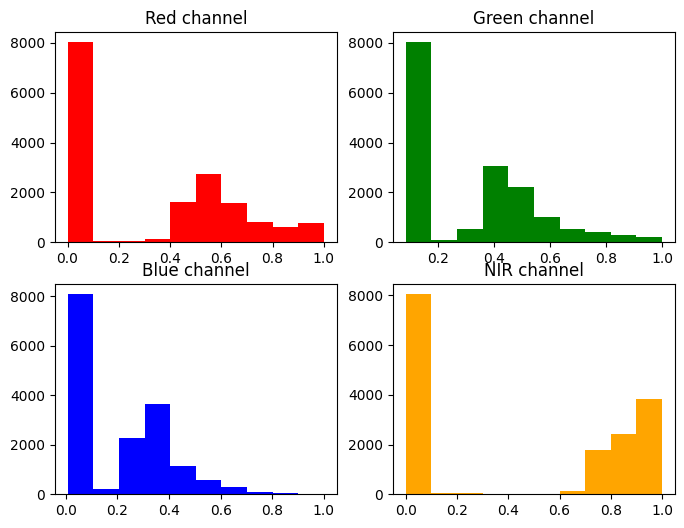

In [11]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.hist(image_layers['red'].flatten(), color='r');
plt.title('Red channel')
plt.subplot(222)
plt.hist(image_layers['green'].flatten(), color='g');
plt.title('Green channel')
plt.subplot(223)
plt.hist(image_layers['blue'].flatten(), color='b');
plt.title('Blue channel')
plt.subplot(224)
plt.hist(image_layers['nir'].flatten(), color='orange');
plt.title('NIR channel');

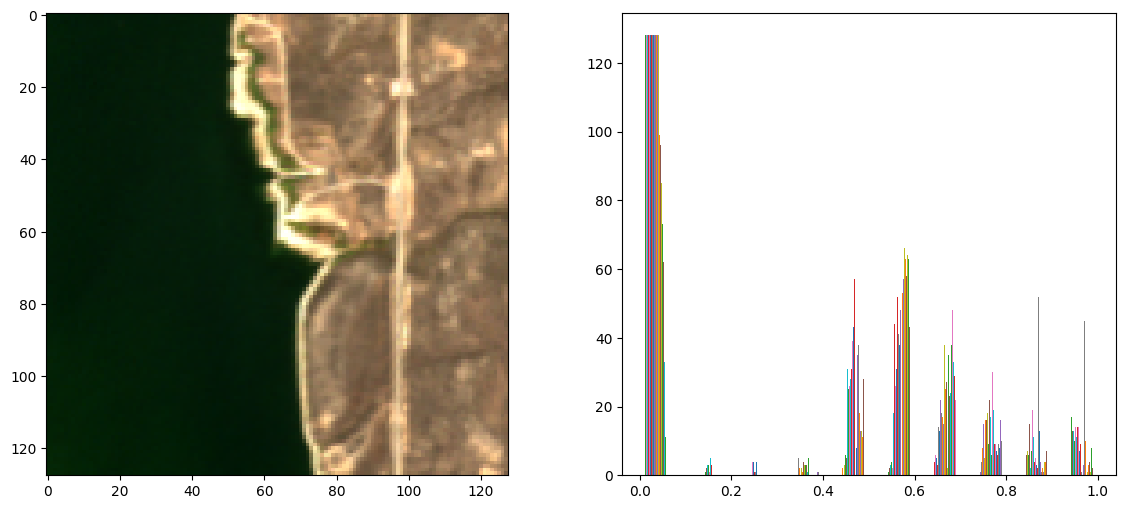

In [12]:
# RGB image from individual channels
rgb_image = np.array(
        [image_layers['red'],
         image_layers['green'],
         image_layers['blue']]
        )

# show normalized image (range shifted to approximately 0-255, no hard limit though)
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((rgb_image), axes=[1, 2, 0]));
plt.subplot(122)
plt.hist(rgb_image[0]);

# plt.imshow(np.transpose((rgb_image), axes=[1, 2, 0]));

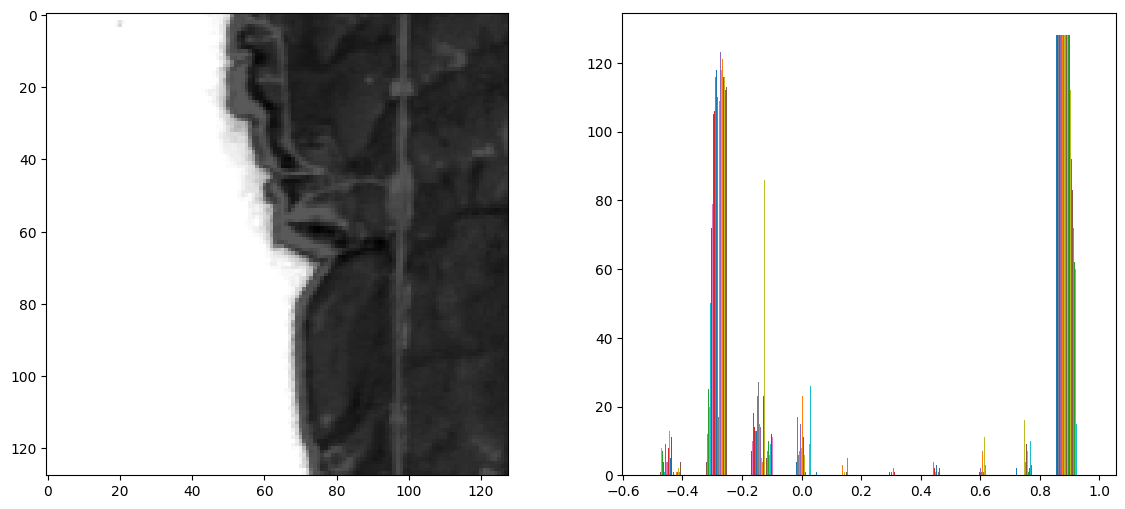

In [13]:
# NDWI - Normalized Difference Water Index
# Sentinel-2 NDWI = (green - NIR) / (green + NIR)
# source: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/
# another source: https://en.wikipedia.org/wiki/Normalized_difference_water_index
ndwi_mask, ndwi_image = get_ndwi_mask(image_layers, ndwi_limit=0.12)

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((ndwi_image), axes=[1, 2, 0]), cmap='gray');
plt.subplot(122)
plt.hist(ndwi_image[0]);

#plt.imshow(np.transpose((ndwi_image), axes=[1, 2, 0]), cmap='gray');

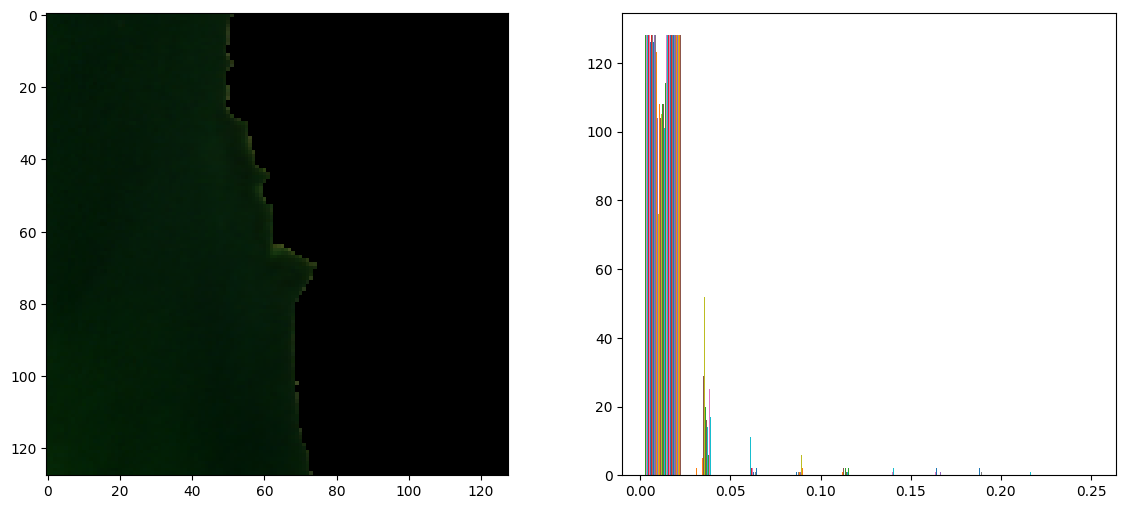

In [14]:
masked_image = np.array([
    image_layers['red'  ] * ndwi_mask,
    image_layers['green'] * ndwi_mask,
    image_layers['blue' ] * ndwi_mask,
    #image_layers['nir'  ] * ndwi_mask,
])

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((masked_image), axes=[1, 2, 0]), cmap='gray');
plt.subplot(122)
plt.hist((masked_image)[0]);

# plt.imshow(np.transpose((masked_image), axes=[1, 2, 0]), cmap='gray');

In [15]:
# Create complete sentinel image with 8 layers
# Layers are: Red, Green, Blue, NIR, Red masked, Green masked, Blue masked, NIR masked
# Masked layers contain only pixels that show water
full_image = np.array([
    image_layers['red'  ],
    image_layers['green'],
    image_layers['blue' ],
    image_layers['nir'  ],
    image_layers['red'  ] * ndwi_mask,
    image_layers['green'] * ndwi_mask,
    image_layers['blue' ] * ndwi_mask,
    image_layers['nir'  ] * ndwi_mask,
    ])

In [16]:
# 8 layers with each 128x128 pixels
full_image.shape

(8, 128, 128)

In [17]:
# value range 0.0 to 1.0
full_image.min(), full_image.max()

(0.0, 1.0)

### Download all satellite images of the dataset



In [18]:
BENCHMARK_DATA_DIR = DATA_DIR / "sat_images"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR / "image_arrays_8_layer_2"
IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)

In [19]:
dataset.head()

,uid,latitude,longitude,date,split,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,NaN,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3.0,111825.0


## Downloading all images
* takes ~6 hours
* requires ~9GB of free space

In [20]:
# This cell takes a LONG time because it iterates over all data!

# save errored id's
errored_ids = []

for row in (pbar := tqdm(dataset.itertuples(), total=len(dataset))):
    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

        # # convert image to 1-dimensional features
        # image_features = image_to_features(image_array)
        # features_dict[row.uid] = image_features

    # search and load the image array if not
    else:
        try:
            image_layers, result_flag = collect_sat_image_layers(row, 
                                                    sat_image_catalog, 
                                                    image_size=128, 
                                                    verbose=False, 
                                                    check_for_water=True, 
                                                    limit=0.12,
                                                    days=15
                                                    )

            ndwi_mask, _ = get_ndwi_mask(image_layers, ndwi_limit=0.12)

            # Create complete sentinel image with 8 layers
            full_image = np.array([
                image_layers['red'  ],
                image_layers['green'],
                image_layers['blue' ],
                image_layers['nir'  ],
                image_layers['red'  ] * ndwi_mask,
                image_layers['green'] * ndwi_mask,
                image_layers['blue' ] * ndwi_mask,
                image_layers['nir'  ] * ndwi_mask,
            ])

            # save image array so we don't have to rerun
            with open(image_array_pth, "wb") as f:
                np.save(f, full_image)

            # store info about image file in dataset
            dataset.loc[dataset['uid'] == row.uid, ['image_src']] = result_flag

            pbar.set_description(f"Processing {row.uid} --> {result_flag}")
            # # convert image to 1-dimensional features
            # image_features = image_to_features(image_array)
            # features_dict[row.uid] = image_features

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

Processing zzzi --> no_image: 100%|██████████| 23570/23570 [7:46:13<00:00,  1.19s/it]   


In [21]:
# see how many ran into errors
print(f"number of errors occured: {len(errored_ids)}")

number of errors occured: 35


In [22]:
errored_ids

['alwh',
 'bslg',
 'dbci',
 'egjs',
 'eqkm',
 'gwei',
 'gygq',
 'hdvw',
 'hhlw',
 'hklc',
 'hsqr',
 'ifel',
 'ifwc',
 'jdvp',
 'jmvw',
 'juny',
 'jztb',
 'ljln',
 'msjt',
 'nttf',
 'nyul',
 'oesl',
 'ojsc',
 'oomm',
 'prpz',
 'qken',
 'qpeh',
 'rygl',
 'ugqe',
 'uhfr',
 'ushn',
 'vblk',
 'wrqa',
 'wvkh',
 'wzxe']

In [23]:
# save dataset with (image info) into file
dataset.to_csv(DATA_DIR / "dataset_long_sat_images.csv", index=False)

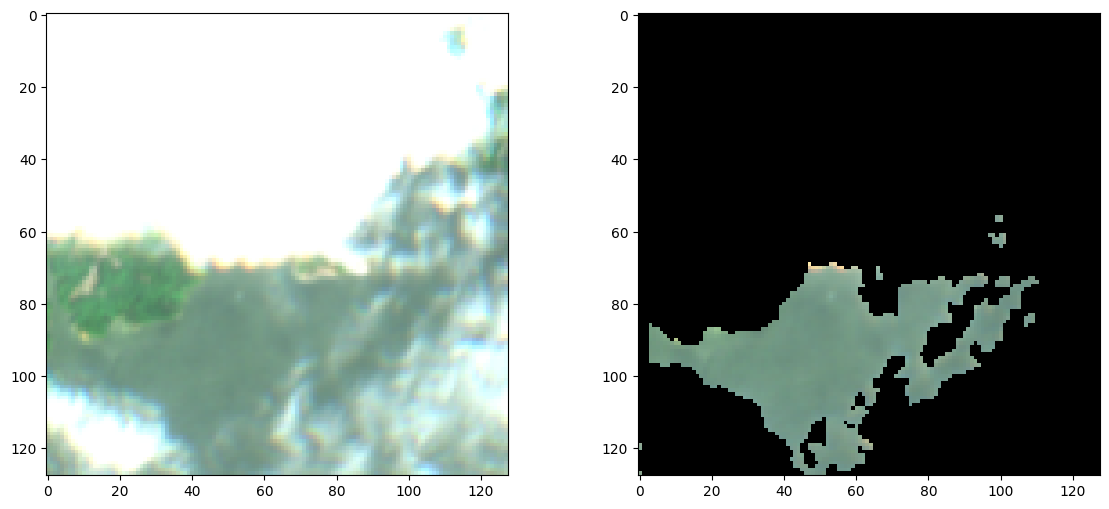

In [24]:
# Try to load one of the saved files to see if everything is working
filepath = IMAGE_ARRAY_DIR / f"aabm.npy"
loaded_layers = np.load(filepath)

# RGB image from individual channels and masked image from masked channels
rgb_image = np.array(
        [loaded_layers[0],
         loaded_layers[1],
         loaded_layers[2]]
        )
masked_image = np.array(
        [loaded_layers[4],
         loaded_layers[5],
         loaded_layers[6]]
        )
# show normalized image (range shifted to approximately 0-255, no hard limit though)
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((rgb_image), axes=[1, 2, 0]));
plt.subplot(122)
plt.imshow(np.transpose((masked_image), axes=[1, 2, 0]));

#plt.imshow(np.transpose((rgb_image), axes=[1, 2, 0]));

In [25]:
dataset.image_src.value_counts()

no_image    3571
sentinel    2831
landsat       80
Name: image_src, dtype: int64